In [1]:
import pandas as pd
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [2]:
%matplotlib inline

In [3]:
sns.set_style('darkgrid')

In [7]:
conn = psycopg2.connect("dbname='FVSOut' user='postgres' host='localhost' port='5433'") # password in pgpass file
SQL = '''
SELECT parcel.parcelid, SUM(acres) AS acres, SUM(baucore) AS core_bau, SUM(fsccore) AS core_fsc,
    SUM(nonrip_fsc) AS nonrip_fsc, SUM(nonrip_bau) AS nonrip_bau, state
FROM parcel, state
WHERE parcel.standid = state.standid AND parcel.parcelid NOT IN (26, 31, 39)
GROUP BY parcel.parcelid, state.state;
'''
# read the query into a pandas dataframe
parcels = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [8]:
parcels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 7 columns):
parcelid      66 non-null int64
acres         66 non-null float64
core_bau      66 non-null float64
core_fsc      66 non-null float64
nonrip_fsc    66 non-null float64
nonrip_bau    66 non-null float64
state         66 non-null object
dtypes: float64(5), int64(1), object(1)
memory usage: 3.7+ KB


In [9]:
parcels.head()

,parcelid,acres,core_bau,core_fsc,nonrip_fsc,nonrip_bau,state
0,51,203.9,0.86,6.10,198.03,201.44,WA
1,12,135.7,0.27,11.28,124.12,134.94,OR
2,53,3668.3,44.46,84.95,3583.24,3583.24,OR
3,49,18.6,0.00,0.00,18.69,18.69,WA
4,33,632.8,11.16,47.66,585.07,604.22,WA


In [10]:
parcels['rip_fsc'] = parcels.acres - parcels.nonrip_fsc
parcels['rip_bau'] = parcels.acres - parcels.nonrip_bau
parcels['pctrip_fsc'] = parcels.rip_fsc / parcels.acres
parcels['pctrip_bau'] = parcels.rip_bau / parcels.acres
parcels['pctcore_fsc'] = parcels.core_fsc / parcels.acres
parcels['pctcore_bau'] = parcels.core_bau / parcels.acres

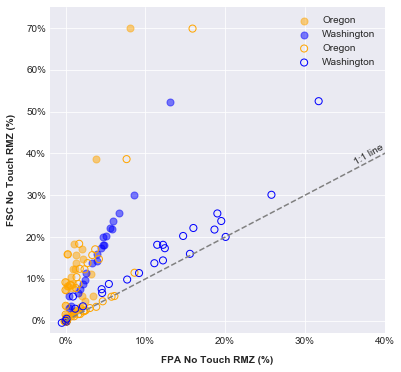

In [11]:
fig, ax = plt.subplots(1, figsize=(6,6))
parcels.loc[parcels.state == 'OR'].plot.scatter(x='pctcore_bau', y='pctcore_fsc', s=50, alpha=0.5,
                                                ax=ax, label='Oregon', color='orange', )
parcels.loc[parcels.state == 'WA'].plot.scatter(x='pctcore_bau', y='pctcore_fsc', s=50, alpha=0.5,
                                                ax=ax, label='Washington', color='blue')
parcels.loc[parcels.state == 'OR'].plot.scatter(x='pctrip_bau', y='pctrip_fsc', s=50,
                                               ax=ax, label='Oregon', c='none', edgecolors='orange')
parcels.loc[parcels.state == 'WA'].plot.scatter(x='pctrip_bau', y='pctrip_fsc', s=50, 
                                               ax=ax, label='Washington', c='none', edgecolors='blue')
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='gray', linestyle='--')
ax.set_xlim(-0.02,0.2)
ax.set_ylim(-0.03,0.75)
ax.set_xticks(np.arange(0,0.5,0.1))
ax.set_yticks(np.arange(0,0.8,0.1))
ax.set_ylabel('FSC No Touch RMZ (%)', weight='bold', labelpad=10)
ax.set_xlabel('FPA No Touch RMZ (%)', weight='bold', labelpad=10)
ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
ax.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
plt.text(0.36,0.41, '1:1 line', rotation=30)
plt.legend(loc='upper right')
plt.savefig('FVSvFPA_RMZcore.png');

In [12]:
# data = pd.read_csv('C:/GitHub/FSC_Case_Studies/Data/rxAll.csv')

conn = psycopg2.connect("dbname='FVSOut' user='postgres' host='localhost' port='5433'") # password in pgpass file
SQL = '''
SELECT *
FROM rxall
WHERE parcel NOT IN (26, 31, 39);
'''
# read the query into a pandas dataframe
data = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [13]:
# join with the parcel table to get the state for each parcel
data = pd.merge(left=data, right=parcels[['parcelid', 'state']], left_on='parcel', right_on='parcelid').drop('parcelid', axis=1)
data = data.sort_values(by=['parcel', 'rx', 'year'])

# rename some of the scenarios to intuitive names
data['scenario'] = data.rx.replace(to_replace={'BAU':'BAU', 'FSC':'SHORT~FSC', 'BAU_long':'LONG~FPA', 'FSC_long':'LONG~FSC'})

In [17]:
data.head()

,parcel,year,cumulative_mbf,npv_total,aboveground_total_live,aboveground_merch_live,belowground_live,standing_dead,forest_down_dead_wood,forest_floor,...,bdft,rbdft,nfv_total,total_undiscounted_cost,total_discounted_cost,rx,state,scenario,tree_carbon,ARBhwp
0,1,2014,15.877719,6359.791291,9.164921,6.352363,2.164351,0.067172,14.411205,7.546139,...,19351.692260,15889.763110,6913.791996,5619.614062,5579.388857,BAU,OR,BAU,11.396444,10.936988
1,1,2019,18.680807,7120.330429,5.686210,3.245627,1.073177,0.073211,9.893122,6.578778,...,4657.563719,2803.088129,7968.379814,6803.312058,6476.928413,BAU,OR,BAU,6.832598,13.079452
2,1,2024,18.933255,7089.215163,6.905051,3.852143,1.531415,0.105400,8.056472,6.320127,...,2493.466706,252.753126,7911.378966,7083.309083,6625.946941,BAU,OR,BAU,8.541866,13.249508
3,1,2029,19.099142,7046.452604,10.690922,4.597974,2.555180,0.149323,6.852445,6.269231,...,2944.958101,165.886826,7812.840197,7339.988332,6729.043910,BAU,OR,BAU,13.395425,13.374743
4,1,2034,19.481569,7047.697849,19.320394,11.409910,4.224432,0.199533,5.915127,6.338728,...,3430.311735,382.426601,7814.564730,7668.355199,6834.461875,BAU,OR,BAU,23.744359,13.645292


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10560 entries, 0 to 10539
Data columns (total 34 columns):
parcel                       10560 non-null int64
year                         10560 non-null int64
cumulative_mbf               10560 non-null float64
npv_total                    10560 non-null float64
aboveground_total_live       10560 non-null float64
aboveground_merch_live       10560 non-null float64
belowground_live             10560 non-null float64
standing_dead                10560 non-null float64
forest_down_dead_wood        10560 non-null float64
forest_floor                 10560 non-null float64
forest_shrub_herb            10560 non-null float64
total_stand_carbon           10560 non-null float64
total_removed_carbon         10560 non-null float64
carbon_released_from_fire    10560 non-null float64
products                     10560 non-null float64
landfill                     10560 non-null float64
energy                       10560 non-null float64
emissions  

### Implementing California Air Resources Board accounting for harvest wood products.

We will folllow the California ARB accounting approach for carbon storage in wood products. 

The 2015 California ARB [Forest Carbon Offset Project Protocol](https://www.arb.ca.gov/cc/capandtrade/protocols/usforest/usforestprojects_2015.htm) accounts for carbon stored in products by defining the disposition of removed marchantable carbon into the products pool over time.

In the Western Cascades "Assessment Area", the ARB protocol specifies the following factors:

| Description | Softwood Lumber | Hardwood Lumber | Plywood | Oriented Strand Board | Non-structural Panels | Miscellaneous | Paper |
|---|---|---|---|---|---|---|---|
| % in each class | 75.3% | 4.3% | 11.4% | 0.0% | 0.1% | 0.5% | 8.4% |
| 100-yr avg. storage | 46.3% | 25.0% | 48.4% | 58.2% | 38.0% | 17.6% | 5.8% |
| avg. storage in in-use products | 34.9% | 1.1% | 5.5% | 0.0% | 0.0% | 0.1% | 0.5% |

The sum of merchantable carbon removed that remains across product categories (averaged over 100 years) is __42.1%__. We will apply this proportion to the volume of carbon in the merchantable portions of trees removed over time.

In [19]:
data['ARBhwp'] = data.merch_carbon_removed * 0.421

### Implementing California Air Resources Board accounting for market effects leakage.

We will folllow the California ARB accounting approach to account for the displacement of harvesting outside the "project area". 

The 2015 California ARB [Forest Carbon Offset Project Protocol](https://www.arb.ca.gov/cc/capandtrade/protocols/usforest/usforestprojects_2015.htm) describes market leakage as "Secondary Effects Emissions," which is calculated as:

If $\sum\limits_{n=1}^{y} AC_{se,n} - BC_{se,n} >= 0 $: then  $SE_y = 0$

If $\sum\limits_{n=1}^{y} AC_{se,n} - BC_{se,n} < 0 $: then $SE_y = (AC_y - BC_y) * 0.20 $

Where,<br>
$SE_y$ = Estimated annual secondary effects (MT $CO_2e$)<br>
$y$ = The reporting period<br>
$AC_{se,n}$ = Actual amount of carbon in standing live and standing dead trees (whole tree including belowground biomass and bark) harvested by reporting period $y$<br>
$BC_{se,n}$ = Estimated average baseline amount of carbon in standing live and standing dead trees (whole tree including belowground biomass and bark) that would have been harvested by reporting period $y$



In [21]:
# FVS outputs total_removed_carbon in the FVS_Carbon report as the amount of above-ground carbon removed each period
# To follow the ARB requirement to also account for belowground carbon in harvested trees, we'll need to update the FVS output

# the ratio of amount of "tree carbon" (above- and below-ground live + standing dead) to above-ground tree carbon
ratio = data.tree_carbon/(data.aboveground_total_live + data.standing_dead)

data['periodic_removed_carbon_alltree'] = data.total_removed_carbon * ratio

# now calculate the cumulative amount of total removed carbon
cols = ['parcel', 'rx', 'year', 'periodic_removed_carbon_alltree']
data['cumulative_removed_carbon_alltree'] = data[cols].groupby(by=['parcel', 'rx']).cumsum()['periodic_removed_carbon_alltree']

In [33]:
def calc_leakage(row):
    '''
    For each row in the data, looks up the amount of harvested carbon under the BAU scenario 
    for the same parcel and year, and then calculates market effects leakage per the ARB protocol.
    '''
    bau_mask = (data.rx == 'BAU') & (data.year == row.year) & (data.parcel == row.parcel)
    bau_removed = data.loc[bau_mask, 'periodic_removed_carbon_alltree'].values[0]
    bau_cum_removed = data.loc[bau_mask, 'cumulative_removed_carbon_alltree'].values[0]
    
    if row.cumulative_removed_carbon_alltree < bau_cum_removed :
        leakage = (row.periodic_removed_carbon_alltree - bau_removed) * 0.20
    
    else:
        leakage = 0
        
    return leakage

In [28]:
data['leakage'] = data[['parcel', 'rx', 'year', 'periodic_removed_carbon_alltree', 'cumulative_removed_carbon_alltree']].apply(calc_leakage, axis=1)
cols = ['parcel', 'rx', 'year', 'leakage']
data['cumulative_leakage'] = data[cols].groupby(by=['parcel', 'rx']).cumsum()['leakage']

In [29]:
# calculate carbon stored in the forest and in wood products
data['tree_carbon'] = data.aboveground_total_live + data.belowground_live + data.standing_dead 
data['tot_carbon'] = data.aboveground_total_live + data.belowground_live + data.standing_dead + data.ARBhwp + data.leakage
data['tCO2e'] = data.tot_carbon * 44/12

In [30]:
# calculate cumulative volume removals and total standing + removed volumes
vol_cols = ['rbdft', 'rtcuft', 'rmcuft']
cum_removals = data.groupby(by=['parcel', 'rx', 'year']).sum().groupby(level=[0,1])[vol_cols].cumsum()
data.set_index(['parcel', 'rx', 'year'], inplace=True)
data['cumulative_rbdft'] = cum_removals['rbdft']
data['cumulative_rtcuft'] = cum_removals['rtcuft']
data['cumulative_rmcuft'] = cum_removals['rmcuft']
data.reset_index(inplace=True)
data['stand_plus_remove_bdft'] = data.bdft + data.cumulative_rbdft
data['stand_plus_remove_tcuft'] = data.tcuft + data.cumulative_rtcuft
data['stand_plus_remove_mcuft'] = data.mcuft + data.cumulative_rmcuft

In [31]:
pd.unique(data.rx)

array(['BAU', 'BAU_long', 'FPA_FSC', 'FPAlong_FSC', 'FSC', 'FSC_FPA',
       'FSC_long', 'FSClong_FPA'], dtype=object)

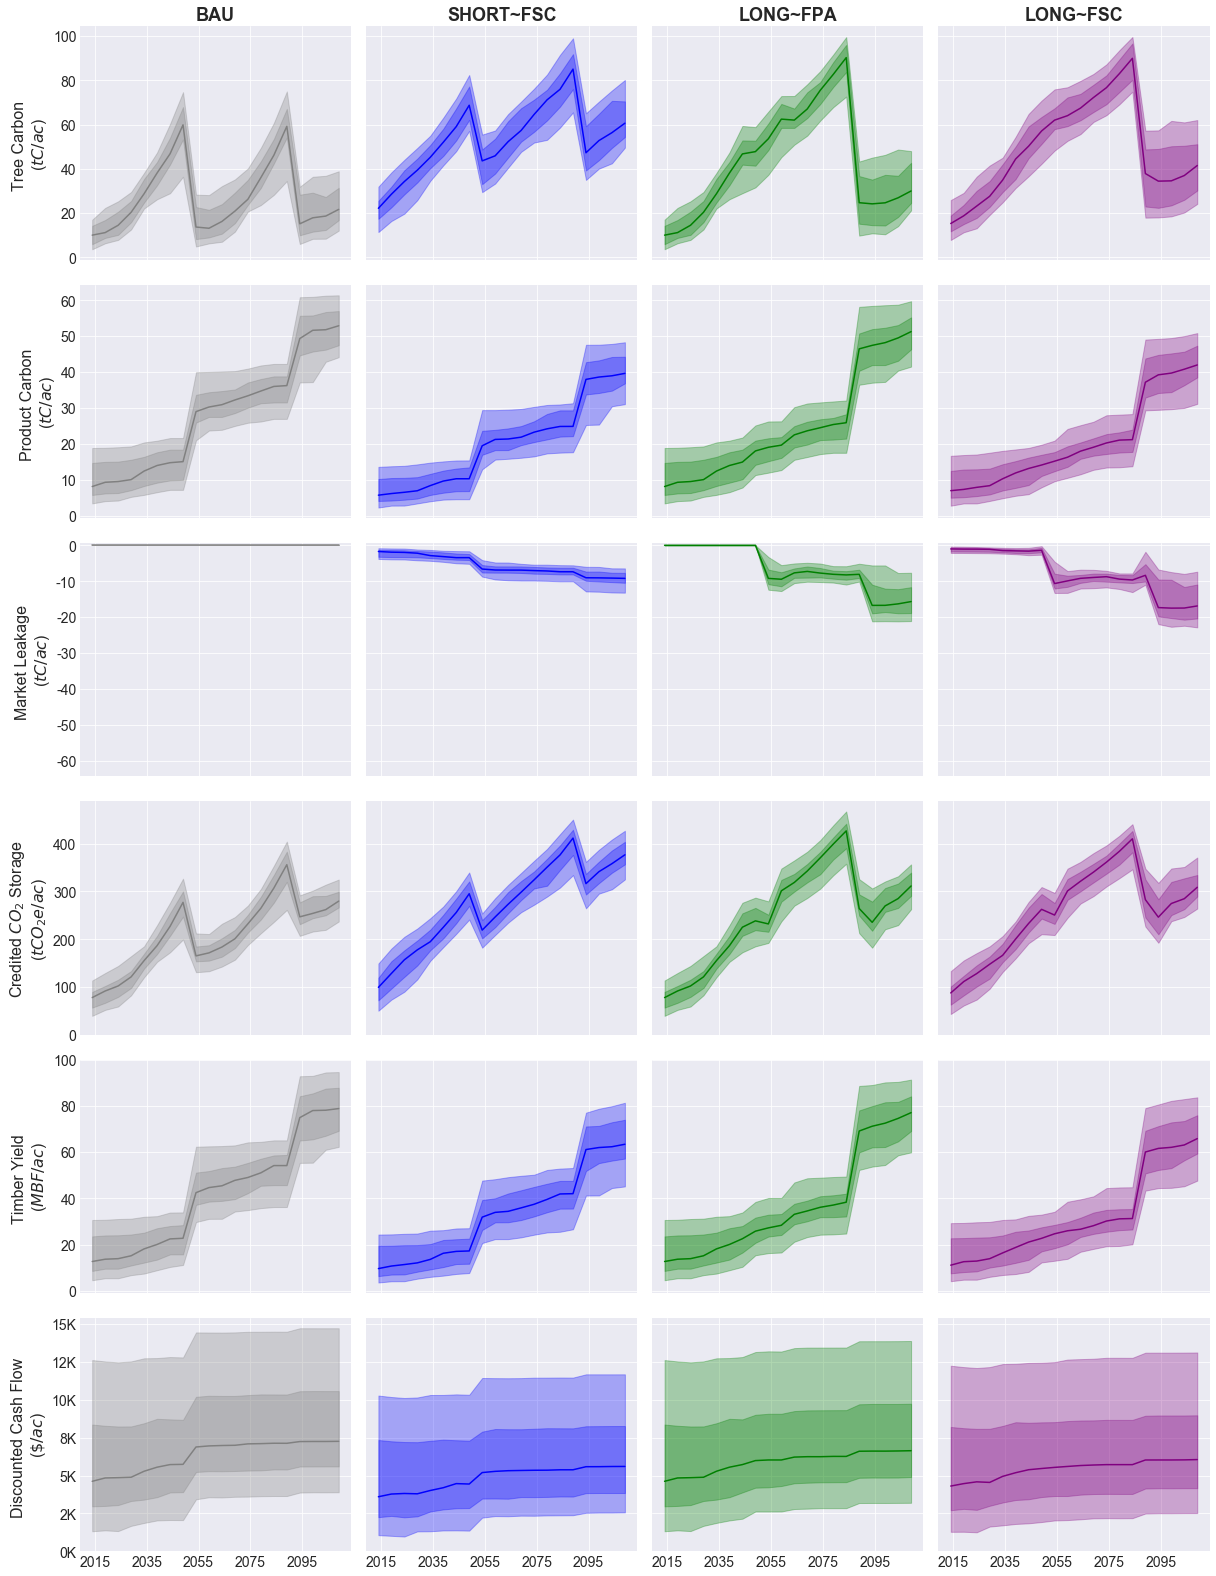

In [104]:
colors = ['gray', 'blue', 'green', 'purple']
pal = colors


fig, axs = plt.subplots(6,4, figsize=(17,22), sharex=True, sharey='row')
cols = ['parcel', 'year', 'scenario', 'tree_carbon', 'ARBhwp', 'cumulative_leakage', 'tCO2e', 'cumulative_mbf', 'npv_total']
metrics = ['tree_carbon', 'ARBhwp', 'cumulative_leakage', 'tCO2e', 'cumulative_mbf', 'npv_total']
scenarios = ['BAU', 'SHORT~FSC', 'LONG~FPA', 'LONG~FSC']
yaxis_labels = ['''Tree Carbon 
($tC/ac$)''',
                '''Product Carbon 
($tC/ac$)''',
                '''Market Leakage 
($tC/ac$)''',
                '''Credited $CO_2$ Storage 
($tCO_2e/ac$)''', 
                '''Timber Yield 
($MBF/ac$)''',
                '''Discounted Cash Flow 
($\$/ac$)''']

i=0
for metric in metrics:
    parcels = data[cols].sort_values(by=['parcel', 'year']).groupby(by=['scenario','year']).quantile([0, 0.10,0.25,0.50,0.75,0.90, 1.0])[metric].unstack(level=-1)
    pivot = pd.pivot_table(parcels.reset_index(), index='year', columns='scenario', values=[0,0.10,0.25,0.50,0.75,0.90,1])
    pivot = pivot.sort_index(axis=1, ascending=False)
    axs[i][0].set_ylabel(metric, fontsize=14) # label y-axis on first graph
    
    # plot the bands
    for j in range(len(scenarios)):
        axs[i][j].fill_between(x=pivot.index, 
                              y1=pivot[0.10][scenarios[j]], 
                              y2=pivot[0.90][scenarios[j]],
                              alpha=0.3, color=pal[j])
        axs[i][j].fill_between(x=pivot.index, 
                              y1=pivot[0.25][scenarios[j]], 
                              y2=pivot[0.75][scenarios[j]],
                              alpha=0.3, color=pal[j])
#         axs[i][j].fill_between(x=pivot.index, 
#                       y1=pivot[0][scenarios[j]], 
#                       y2=pivot[1][scenarios[j]],
#                       alpha=0.3, color=pal[j])
        axs[i][j].plot(pivot[0.5][scenarios[j]], lw=1.5, color=pal[j])    
    i+=1

# label the plots
for i in range(len(axs[0])):
    axs[0][i].set_title(scenarios[i], fontsize=18, weight='bold') # label title on top row
    axs[-1][i].xaxis.set_tick_params(labelsize=14) # ticks on bottom row

for i in range(len(axs)):
    axs[i][0].set_ylabel(yaxis_labels[i], fontsize=16) # axis label on first column
    axs[i][0].yaxis.set_major_formatter(FuncFormatter('{0:,.0f}'.format))
    axs[i][0].yaxis.set_tick_params(labelsize=14)

def currency(x, pos):
    return '{:1.0f}K'.format(x*1e-3)

axs[-1][0].yaxis.set_major_formatter(FuncFormatter(currency))
                               
# set products to be on same axis range as leakage
prod_min, prod_max = axs[1][0].get_ylim() 
axs[2][0].set_ylim(-prod_max, -prod_min)

plt.setp(axs, xticks=range(2015,2115,20))
plt.setp(axs[1], yticks=range(0,65,10)) # products yticks
plt.setp(axs[2], yticks=range(-60,5,10)) # leakage yticks
plt.setp(axs[3], yticks=range(0,500,100)) # credited tco2e yticks
plt.setp(axs[4], yticks=range(0,120,20)) # timber yield yticks
plt.setp(axs[5], yticks=range(0,17500,2500), xlabel='') # cash flow yticks

plt.tight_layout()
plt.savefig('scenario_lines.png');

In [105]:
cols = ['parcel', 'year', 'scenario', 'tree_carbon', 'ARBhwp', 'cumulative_leakage', 'tCO2e', 'cumulative_mbf', 'npv_total']
metrics = ['tree_carbon', 'ARBhwp', 'cumulative_leakage', 'tCO2e', 'cumulative_mbf', 'npv_total']
metrics.append(['parcel', 'year'])
metrics

['tree_carbon',
 'ARBhwp',
 'cumulative_leakage',
 'tCO2e',
 'cumulative_mbf',
 'npv_total',
 ['parcel', 'year']]

In [106]:
cols = ['parcel', 'year', 'state', 'scenario', 'cumulative_mbf', 'tCO2e', 'npv_total']
all_rx = data[cols].sort_values(by=['parcel', 'year']).groupby(by=['scenario','parcel','state']).agg({'cumulative_mbf':'max', 'tCO2e':'mean', 'npv_total':'max'})
all_rx['tCO2e_MBF'] = all_rx.tCO2e / all_rx.cumulative_mbf

In [107]:
long_fpa = all_rx.xs('LONG~FPA') - all_rx.xs('BAU')
long_fsc = all_rx.xs('LONG~FSC') - all_rx.xs('BAU')
short_fsc = all_rx.xs('SHORT~FSC') - all_rx.xs('BAU')
long_fpa_pct = (all_rx.xs('LONG~FPA') - all_rx.xs('BAU'))/all_rx.xs('BAU')
long_fsc_pct = (all_rx.xs('LONG~FSC') - all_rx.xs('BAU'))/all_rx.xs('BAU')
short_fsc_pct = (all_rx.xs('SHORT~FSC') - all_rx.xs('BAU'))/all_rx.xs('BAU')

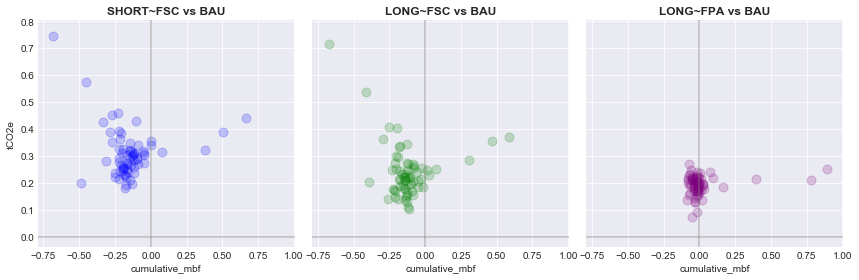

In [127]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True, sharex=True)
scenarios = [short_fsc_pct, long_fsc_pct, long_fpa_pct]
titles = ['SHORT~FSC vs BAU', 'LONG~FSC vs BAU', 'LONG~FPA vs BAU']
colors = ['blue', 'green', 'purple']
for i in range(3):
    scenarios[i].plot.scatter(x='cumulative_mbf', y='tCO2e', 
                              ax=axs[i], color=colors[i], alpha=0.2, s=80)
    axs[i].axhline(y=0, color='grey', alpha=0.5)
    axs[i].axvline(x=0, color='grey', alpha=0.5)
    axs[i].set_title(titles[i], weight='bold')
plt.tight_layout();

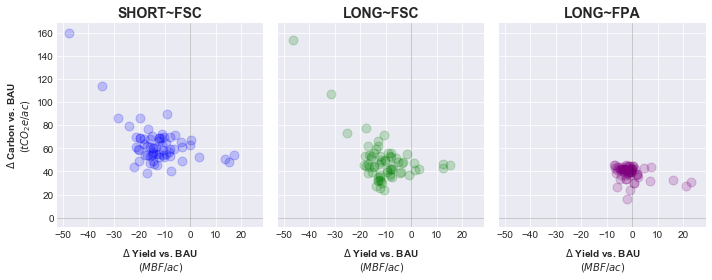

In [126]:
fig, axs = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
scenarios = [short_fsc, long_fsc, long_fpa]
colors = ['blue', 'green', 'purple']
titles = ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']
for i in range(3):
    axs[i].axvline(x=0, color='black', lw=1, alpha=0.2)
    axs[i].axhline(y=0, color='black', lw=1, alpha=0.2)
    scenarios[i].plot.scatter(x='cumulative_mbf', y='tCO2e', 
                              ax=axs[i], color=colors[i], alpha=0.2, s=80)

    axs[i].set_xlabel('''$\Delta$ Yield vs. BAU
$(MBF/ac)$''', weight='bold', labelpad=8)
    axs[i].set_title(titles[i], fontsize=14, weight='bold')

#axs[0].set_ylim(-5,200)
axs[0].set_xticks(range(-50,25, 10))
axs[0].set_ylabel('''$\Delta$ Carbon vs. BAU
$(tCO_2e/ac)$''', weight='bold')

plt.tight_layout()
plt.savefig('scenario_scatter_carbontimber.png');

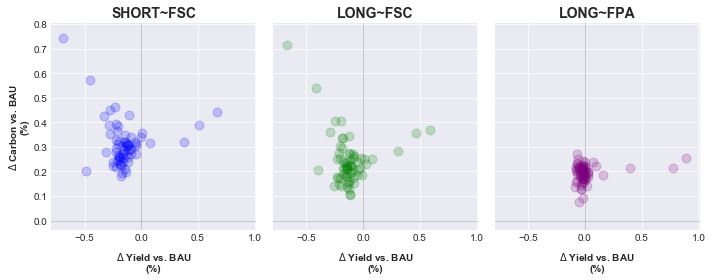

In [128]:
fig, axs = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
scenarios = [short_fsc_pct, long_fsc_pct, long_fpa_pct]
colors = ['blue', 'green', 'purple']
titles = ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']
for i in range(3):
    axs[i].axvline(x=0, color='black', lw=1, alpha=0.2)
    axs[i].axhline(y=0, color='black', lw=1, alpha=0.2)
    scenarios[i].plot.scatter(x='cumulative_mbf', y='tCO2e', 
                              ax=axs[i], color=colors[i], alpha=0.2, s=80)

    axs[i].set_xlabel('''$\Delta$ Yield vs. BAU
(%)''', weight='bold', labelpad=8)
    axs[i].set_title(titles[i], fontsize=14, weight='bold')
#axs[0].set_ylim(-5,200)
axs[0].set_ylabel('''$\Delta$ Carbon vs. BAU
(%)''', weight='bold')
plt.tight_layout()
plt.savefig('scenario_scatter_carbontimber_percent.png');

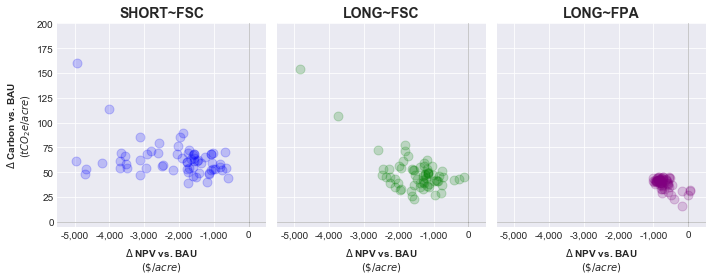

In [129]:
fig, axs = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
scenarios = [short_fsc, long_fsc, long_fpa]
colors = ['blue', 'green', 'purple']
titles = ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']
for i in range(3):
    axs[i].axvline(x=0, color='black', lw=1, alpha=0.2)
    axs[i].axhline(y=0, color='black', lw=1, alpha=0.2)
    scenarios[i].plot.scatter(x='npv_total', y='tCO2e', 
                              ax=axs[i], color=colors[i], alpha=0.2, s=80)
    axs[i].xaxis.set_major_formatter(FuncFormatter('{:,.0f}'.format))

    axs[i].set_xlabel('''$\Delta$ NPV vs. BAU
$(\$/acre)$''', weight='bold', labelpad=8)
    axs[i].set_title(titles[i], fontsize=14, weight='bold')
axs[0].set_ylim(-5,200)
axs[0].set_xlim(-5500,500)
axs[0].set_ylabel('''$\Delta$ Carbon vs. BAU
$(tCO_2e/acre)$''', weight='bold')
plt.tight_layout()
plt.savefig('scenario_scatter_carboncash.png');

In [112]:
styles = {'cumulative_mbf':'{:,.1f}', 'npv_total':'${:,.0f}', 'tCO2e': '{:,.0f}', 'tCO2e_MBF':'{:.2f}', 'lca_tCO2e': '{:,.0f}', 'lca_tCO2e_MBF':'{:.2f}'}
all_rx.reset_index().groupby(by=['state', 'scenario']).mean().drop('parcel', axis=1).style.format(styles)

In [113]:
styles = {'cumulative_mbf':'{:,.1f}', 'npv_total':'${:,.0f}', 'tCO2e': '{:,.0f}', 'tCO2e_MBF':'{:.2f}', 'lca_tCO2e': '{:,.0f}', 'lca_tCO2e_MBF':'{:.2f}'}
all_rx.reset_index().groupby(by=['state', 'scenario']).quantile([0.10, 0.90]).drop('parcel', axis=1).style.format(styles)

## Tables of differences between alternative scenarios vs. BAU

### LONG~FSC

In [114]:
long_fsc_pct.groupby(level=1).mean().style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_total,tCO2e_MBF
state,,,,
OR,-12.3%,25.8%,-22.4%,53.2%
WA,-12.3%,21.2%,-20.4%,40.4%


In [115]:
long_fsc_pct.groupby(level=1).quantile([0.10, 0.90]).style.format("{:.1%}")

In [116]:
# absolute difference between FSC-LONG and BAU
styles = {'cumulative_mbf':'{:,.1f}', 'npv_total':'${:,.0f}', 'tCO2e': '{:,.0f}', 'lca_tCO2e': '{:,.0f}'}
long_fsc.groupby(level=1).mean().style.format(styles)

,cumulative_mbf,tCO2e,npv_total,tCO2e_MBF
state,,,,
OR,-11.3,50,"$-1,604",1.38405
WA,-9.4,45,"$-1,355",1.28504


In [117]:
styles = {'cumulative_mbf':'{:,.1f}', 'npv_total':'${:,.0f}', 'tCO2e': '{:,.0f}', 'lca_tCO2e': '{:,.0f}'}
long_fsc.groupby(level=1).quantile([0.10, 0.90]).style.format(styles)

In [118]:
# ignoring state differences
pd.DataFrame(long_fsc_pct.mean()).T.style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_total,tCO2e_MBF
0,-12.3%,24.0%,-21.6%,48.3%


In [119]:
long_fsc_pct.quantile([0.10, 0.90]).style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_total,tCO2e_MBF
0.1,-22.8%,14.8%,-35.2%,24.2%
0.9,-1.7%,35.0%,-10.5%,63.3%


### SHORT~FSC

In [120]:
short_fsc_pct.groupby(level=1).mean().style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_total,tCO2e_MBF
state,,,,
OR,-15.2%,33.1%,-26.9%,68.3%
WA,-14.0%,27.5%,-24.8%,51.8%


In [121]:
short_fsc_pct.groupby(level=1).quantile([0.10, 0.90]).style.format("{:.1%}")

In [122]:
styles = {'cumulative_mbf':'{:,.1f}', 'npv_total':'${:,.0f}', 'tCO2e': '{:,.0f}', 'lca_tCO2e': '{:,.0f}'}
short_fsc.groupby(level=1).mean().style.format(styles)

,cumulative_mbf,tCO2e,npv_total,tCO2e_MBF
state,,,,
OR,-13.7,65,"$-2,305",1.76326
WA,-10.9,59,"$-1,812",1.63241


In [123]:
# absolute difference between FSC-SHORT and BAU
styles = {'cumulative_mbf':'{:,.1f}', 'npv_total':'${:,.0f}', 'tCO2e': '{:,.0f}', 'lca_tCO2e': '{:,.0f}'}
short_fsc.groupby(level=1).quantile([0.10, 0.90]).style.format(styles)

In [124]:
# ignoring state differences
pd.DataFrame(short_fsc_pct.mean()).T.style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_total,tCO2e_MBF
0,-14.7%,31.0%,-26.1%,62.1%


In [125]:
short_fsc_pct.quantile([0.10, 0.90]).style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_total,tCO2e_MBF
0.1,-27.3%,22.2%,-34.8%,36.1%
0.9,-4.8%,41.0%,-18.1%,87.8%


## Calculate the timber value premium that would be required for FSC scenarios to match NPV of BAU

In [131]:
# to do

## Calculate the carbon value that would be required for FSC scenarios to match NPV of BAU

In [132]:
# to do